# Bandgap Simulator Development  

This notebook demonstrates the development of a bandgap prediction simulator, integrating input features and predictive models to estimate bandgap values for a wide range of solid-state materials.  

*This simulator is adapted from [gomezperalta/perovskites_simulator](https://github.com/gomezperalta/perovskites_simulator).*
  


In [32]:
import pandas as pd
import numpy as np
import tensorflow.keras.models as models
import tensorflow.keras
import matplotlib.pyplot as plt
import matplotlib.colors
import neighdist
import itertools
import os
import re
import xgboost as xgb

'''
# Configuración de los parámetros de matplotlib
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.size'] = 15
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (7.2,4.45)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
'''

cmap = plt.cm.get_cmap('RdYlBu')
norm = matplotlib.colors.BoundaryNorm(np.arange(0,1.1,0.1), cmap.N)

/tmp/ipykernel_86328/811270495.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


### 1. Loading data

#### 1.1 Loading auxiliary data

In [17]:
"""An auxiliary file used to compute the features needed by the ANN"""
datos = pd.read_csv('datosrahm.csv')

maindict = {}
for row in range(datos.shape[0]):
    maindict[datos['Symbol'][row]] = \
    datos.iloc[row,:][['elecPau','atradrahm']].values

elemental_masses = np.load('element_masses.npy', allow_pickle=True).item()

In [18]:
display(pd.DataFrame(maindict))

,H,He,Li,Be,B,C,N,O,F,Ne,...,Fr,Ra,Ac,Th,Pa,U,Np,Pu,Am,Cm
0,2.2,NaN,0.98,1.57,2.04,2.55,3.04,3.44,3.98,NaN,...,0.7,0.9,1.1,1.3,1.5,1.7,1.3,1.3,NaN,NaN
1,1.54,1.34,2.2,2.19,2.05,1.9,1.79,1.71,1.63,1.56,...,2.58,2.92,2.93,2.89,2.85,2.83,2.8,2.78,2.76,2.76


#### 1.2 Loading the trained ANN and the standarization parameters

In [19]:
"""THE ARTIFICIAL NEURAL NETWORK IS LOADED AS WELL AS THE PARAMETERS TO DO THE FEATURE STANDARIZATION"""
directorio = 'Best_Models/July_21_211501_2024_0.019fgsm_0.0001lr_1200_0.0_32_4_hidden_600__b/'
model_dict = np.load(directorio + 'Bgmodel_dict.npy', allow_pickle=True).item()
model = models.load_model(directorio + 'July_21_211501_2024_0.019fgsm_0.0001lr_1200_0.0_32_4_hidden_600.keras')

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120)]                0         []                            
                                                                                                  
 dense_9 (Dense)             (None, 1200)                 145200    ['input_2[0][0]']             
                                                                                                  
 layer_normalization_8 (Lay  (None, 1200)                 2400      ['dense_9[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 1200)                 0         ['layer_normalization_8[

#### 1.3 Definition of the occupied sites in an aristotype perovskite

In [21]:
"""Occupied sites in an aristotype perovskite"""

wyckcub = {0:{'A' : np.asarray([[0.0,0.0,0.0]])},
          1:{'B' : np.asarray([[0.5,0.5,0.5]])},
          2:{'X' : np.asarray([[0.5,0.5,0.0],[0.5,0.0,0.5],[0.0,0.5,0.5]])}}

### 2. Helping functions

Here we have a set o auxiliary functions to compute the features and scan the different material proposals with the ANN.

In [22]:
def compute_quotients(X = np.zeros((1,1,2))):
    """
    Returns the atomic radii pair quotients and the atomic radii 
    pair sum - quotients as a numpy array. Thjs is the first part of
    all the features used to train the ANNs
    Parameters:
        X: A numpy array, which is created with the function raw_features_extractor
    Returns:
        X: A numpy array of dimension [samples,1,features]
    """
    
    rad = X[:,:,1]

    X = np.reshape(X,(X.shape[0],1,X.shape[1]*X.shape[2]))

    drad = np.asarray([[item[0]/item[1] if item[1] != 0 else 0 for item in list(itertools.combinations(rad[sample],2))] \
                        for sample in range(X.shape[0])])

    dradsum = np.asarray([[item[0]/item[1] if item[1] != 0 else 0 for item in itertools.combinations([ \
                       item[0]+item[1] for item in list(itertools.combinations(rad[sample],2))], 2)] \
                       for sample in range(drad.shape[0])])
    
    drad = np.reshape(drad,(drad.shape[0],1,drad.shape[-1]))
    drads = np.reshape(dradsum,(dradsum.shape[0],1,dradsum.shape[-1]))

    X = np.concatenate((drad,drads), axis=2)
        
    return X

def density(elements = [['Ca'],['Ti'], ['Te']], 
            compositions = [[1.0], [1.0],[1.0]],
            multiplicities = [[1],[1],[3]],
            angles = [90,90,90], 
            abc = [5,5,5]):
    """
    Computes the density of a compound based on its composition and unit cell parameters.
    Parameters:

        elements: List of lists containing atomic symbols
        compositions: List of lists with occupancy fractions
        multiplicities: List of lists with site multiplicities
        angles: List of three angles (in degrees) of the unit cell
        abc: List of three lattice parameters
    Returns:
        Density in g/cm³
    """    
    
    em = [[elemental_masses.get(elemento,None) for elemento in item] for item in elements]
    masses = [sum([k*v for k,v in zip(i,j)]) for i,j in zip(em, compositions)]
    zm = [i*j[0] for i,j  in zip(masses, multiplicities)]
    zm = sum(zm)/(6.022*10**23)

    volumen=abc[0]*abc[1]*abc[2]*np.sqrt(1-(np.cos(np.deg2rad(angles[0])))**2 - \
               (np.cos(np.deg2rad(angles[1])))**2-(np.cos(np.deg2rad(angles[2])))**2 + \
               2*np.cos(np.deg2rad(angles[0]))*np.cos(np.deg2rad(angles[1]))*np.cos(np.deg2rad(angles[2])))
    
    return (zm*10**24)/volumen

In [23]:
def add_rad_elec(X = np.ones((1,1,1))):
    """
    This function gets the average atomic radii and electronegativities per site for each compound. 
    Parameters:
	X: a Numpy array
    Returns:
	x: a Numpy array. The dimensions of the array correspond to a tensor of shape 
	(samples,1,atomic radii and electronegativites).
    """
    X = X[:,:,:2]
    x = X.reshape((X.shape[0], 1, X.shape[1]*X.shape[2]))
    return x

In [24]:
def scan_nnoutputs(elements = [['Ca'],['Ti'], ['S']], wef=False,
                   compositions = [[1.0], [1.0],[1.0]], 
                   maxdev = 0.00, stepsize=0.005,
                   sitios = 6, idx=7,latpar=3.0):
    """
    This is the main simulation function that uses the ANN to predict perovskite formation 
    probabilities across a range of lattice parameters.
    Simulates perovskite formation probability for various lattice parameters.
    Parameters:
        elements: List of lists specifying atoms in each site
        compositions: List of lists with occupancy fractions
        maxdev: Maximum deviation from calculated lattice parameter (default 0.2)
        stepsize: Step size for lattice parameter scan (default 0.01)
        sitios: Number of sites (default 6)
        idx: Index for selecting probability output (default 7)
        wef: Boolean to include additional features (default False)
    Returns:
        scanned_latpar: Array of scanned lattice parameters
        probabilities: Array of corresponding probabilities
    """
    
    scann = np.arange(1 - maxdev, 1 + maxdev + stepsize, stepsize)
    
    multiplicities = [[1],[1],[3]]

    sidx = [np.asarray(i)*np.asarray(j) for i,j in zip(compositions, multiplicities)]
    sidx = [k for h in sidx for k in h]
    
    elements2 = [k for j in elements for k in j]
    formula = [i + '$_{' + "%.2f" % j + '}$' for i,j in zip(elements2, sidx)]
    formula = ''.join([i for i in formula])
    
    primfeat = [np.dot(np.asarray(subind), np.asarray([maindict.get(item,None) \
              for item in site])) for site, subind in zip (elements, compositions)]
    
    primfeat = np.asarray(primfeat)
    
    while primfeat.shape[0] != sitios:
        primfeat = np.concatenate((np.zeros((1,primfeat.shape[1])),primfeat), axis = 0)
    
    #latpar = primfeat[2][1] + primfeat[3][1]
    latpar = [latpar]
    multiplicities = np.asarray(multiplicities)
    
    primfeat = primfeat.reshape((1, primfeat.shape[0],primfeat.shape[1]))
    #xgeom = compute_quotients(X=primfeat)
    #print(primfeat.shape)
    xgeom = add_rad_elec(X = primfeat)
    zeros_2=np.zeros((xgeom.shape[0], xgeom.shape[1], 20-xgeom.shape[2]))
    xgeom = np.concatenate((zeros_2, xgeom),axis=2)
    #np.concatenate((xgeom, xgeom2), axis=-1)
    #print(xgeom.shape)
    #display(pd.DataFrame(xgeom[0,0,:]))
    if wef:
        xre = primfeat.reshape(primfeat.shape[0],1,primfeat.shape[1]*primfeat.shape[2])
        xgeom = np.concatenate((xre,xgeom), axis=2)
    
    scann = scann**3
    scanned_latpar = latpar*(scann**(1/3))    

    dist = 25
    
    radii = primfeat[:,:,1]
    
    elec = primfeat[:,:,0]
    elec = elec.reshape((sitios,1))
    
    delec = np.repeat(elec[:,np.newaxis],sitios,axis=2) - \
            np.repeat(elec[:,np.newaxis],sitios,axis=2).T
    delec = delec.reshape((delec.shape[0],delec.shape[2]))

    fr = np.zeros((len(scann),sitios,sitios))
    for item in range(len(scanned_latpar)):

        p, z, n, m = neighdist.positions(pos = wyckcub, 
                                        angles = [90,90,90], 
                                        abc = [scanned_latpar[item],]*3,
                                        dist = dist)
        r = neighdist.rij(mult=m,p=p,zero=z,
                          dist=dist, sites=sitios, radii = np.ravel(radii))
        #display(r)
        temp = np.multiply(r,delec)
        temp = temp[~np.eye(temp.shape[0],
                     dtype=bool)].reshape(temp.shape[0],-1)
        #display(pd.DataFrame(delec))
        # Reshape temp
        #temp_reshaped = np.zeros(delec.shape)
        #temp_reshaped[:, :int(sitios-1)] = temp
        # Assign the reshaped temp to fr[item]
        fr[item] = r

        #fr[item] = temp
    
    fr = fr.reshape((fr.shape[0],1,fr.shape[1]*fr.shape[2]))
    zeros_2 = np.zeros((fr.shape[0], fr.shape[1], 100-fr.shape[2]))
    fr= np.concatenate((zeros_2,fr), axis=2)
    
    xgeom = np.asarray((xgeom,)*len(scann))
    xgeom = xgeom.reshape((xgeom.shape[0],1,xgeom.shape[3]))

    

    if wef:
        densidad = density(elements = elements, compositions = compositions,
                           multiplicities = multiplicities, abc = np.asarray((scanned_latpar,)*3),
                           angles = [90,90,90])

        x = np.concatenate((x, densidad[:, np.newaxis, np.newaxis]), axis=2)

    x = np.concatenate((xgeom, fr),axis=2)
    #print(xgeom.shape,fr.shape)
    x = x.astype(np.float64)
    #print(x.shape)
    xs = (x - model_dict['mean'])/model_dict['std']
    #xs = xs.astype(np.float32)
    #display(x[:,0,:])
    predictions = model.predict(xs[:,0,:], verbose=False)
    return scanned_latpar, predictions
    

In [25]:
def compare_compounds(formulas = list(), abx_probs = dict(), abx_latpar = dict()):
    
    """
    Auxiliary function to plot the computed ANN outputs.

    This function visualizes the probability of different compounds crystallizing
    as perovskites. It creates a plot with the computed probabilities and lattice
    parameters for each given formula.

    Parameters:
    -----------
    formulas : list
        A list of strings where each string represents a chemical formula. 

    Global Variables:
    -----------------
    abx_probs : dict
        A dictionary where keys are chemical formulas and values are arrays of 
        probabilities that the compounds will crystallize as perovskites.

    abx_latpar : dict
        A dictionary where keys are chemical formulas and values are arrays of 
        lattice parameters associated with the compounds.

    Returns:
    --------
    None

    This function does not return any values. It generates a plot showing the 
    probabilities and lattice parameters for each formula in the input list.
    """
    
    fig, axes = plt.subplots(nrows=len(formulas), ncols=1)

    cmap = plt.cm.get_cmap('RdYlBu')
    norm = matplotlib.colors.BoundaryNorm(np.arange(0,1.1,0.1), cmap.N)
    
    for ax, idx, formula in zip(axes.flat, np.arange(0, len(axes.flat),1), formulas):
        nombre = formula[:-1]
        todos = ax.imshow(abx_probs[formula][:,np.newaxis].T,cmap=cmap,norm = norm)
        
        parameter = abx_latpar[formula]

        parameter = ["%.4f" % parameter[i] for i in range(len(parameter)) if i%5 == 0]

        ax.set_title(nombre+'$_{3}$', fontsize= 16)
        ax.set_xticks(np.arange(0,41,5))
        ax.set_xticklabels(parameter, fontsize = 14)
        ax.set_xlabel('Lattice parameter in ' + '$\AA$', fontsize= 14)
        ax.set_xticks(np.arange(-0.5,41,1),minor=True)
        ax.set_yticks([])
        ax.grid(which='minor', color='black', linewidth = '0.50')
    cb = plt.colorbar(todos, cmap = cmap, norm = norm, ax = list(axes.ravel()), shrink = 0.75, 
                      orientation = 'vertical')
    cb.ax.tick_params(labelsize = 14)
    cb.set_label('Probability to crystallize as perovskite', fontsize = 14)
    plt.show()
    
    return 

In [ ]:
def compare_compounds_df(formulas = list(), abx_preds = dict(), abx_latpar = dict(),bandgaps_lit=pd.DataFrame):  
    df_latpar=pd.DataFrame.from_dict(abx_latpar,orient='index')
    df_latpar.columns=['latpar']
    abx_preds_2=np.vstack(list(abx_preds.values())).reshape(len(abx_preds), -1)
    df_preds = pd.DataFrame(abx_preds_2, columns=['gga', 'gga_opt', 'hse', 'hse_opt'])
    df_preds.index=abx_preds.keys()
    df=pd.concat([df_latpar,df_preds],axis=1)
    df=pd.concat([df,bandgaps_lit],axis=1)
    return df.loc[formulas]
    

In [127]:
def compare_compounds_df2(formulas=list(), abx_preds=dict(), abx_latpar=dict(), bandgaps_lit=pd.DataFrame(), handle_duplicates='drop'):
    df_latpar = pd.DataFrame.from_dict(abx_latpar, orient='index')
    df_latpar.columns = ['latpar']
    
    abx_preds_2 = np.vstack(list(abx_preds.values())).reshape(len(abx_preds), -1)
    df_preds = pd.DataFrame(abx_preds_2, columns=['gga', 'gga_opt', 'hse', 'hse_opt'])
    df_preds.index = abx_preds.keys()
    
    df = pd.concat([df_latpar, df_preds], axis=1)
    
    if not df.index.is_unique:
        if handle_duplicates == 'drop':
            df = df[~df.index.duplicated(keep='first')]  
        elif handle_duplicates == 'aggregate':
            df = df.groupby(df.index).mean()  
    
    if not bandgaps_lit.index.is_unique:
        if handle_duplicates == 'drop':
            bandgaps_lit = bandgaps_lit[~bandgaps_lit.index.duplicated(keep='first')]  
        elif handle_duplicates == 'aggregate':
            bandgaps_lit = bandgaps_lit.groupby(bandgaps_lit.index).mean()  
    
    bandgaps_lit = bandgaps_lit.reindex(df.index)
    
    df = pd.concat([df, bandgaps_lit], axis=1)
    
    return df.loc[formulas]



### 3. Exploring the simulation capabilities

In [128]:
#El orden es [['A'], ['B'],['X']], que corresponde a [[cubo],[octa],[anion]]
formcomp = 'K1.0Mg1.0F3.0'
elements = [['K'], ['Mg'],['F']]
compositions = [[1.0],[1.0],[1.0]]
latpar=3.98

In [129]:
latpars, preds = scan_nnoutputs(elements=elements, compositions = compositions, sitios=10, idx=1, wef=False,latpar=latpar)

In [130]:
print(latpars, preds)

[3.98] [[1.6954603 3.7560585 3.2512057 5.683868 ]]


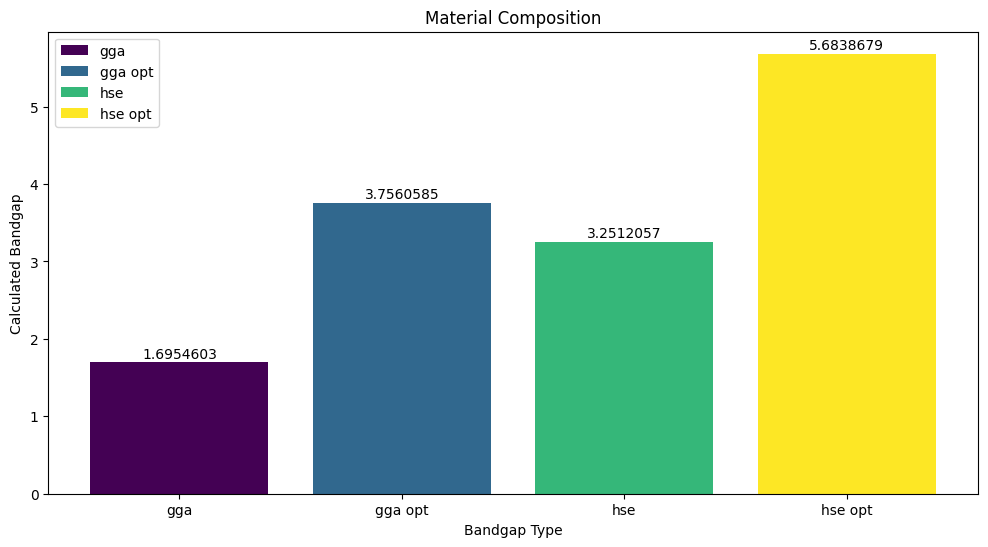

In [131]:
bg_labels = ['gga', 'gga opt', 'hse', 'hse opt']
formcomp = 'Material Composition'
plt.figure(figsize=(12, 6))
plt.title(formcomp)
colors = plt.cm.viridis(np.linspace(0, 1, preds.shape[-1]))

for item in range(preds.shape[-1]):
    bars = plt.bar(item, preds[:, item], color=colors[item], label=bg_labels[item])
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.7f}', ha='center', va='bottom')

plt.xticks(range(len(bg_labels)), bg_labels)
#plt.grid(axis='y')
plt.xlabel('Bandgap Type')
plt.ylabel('Calculated Bandgap')
plt.legend()

plt.show()




#### 3.1 Exploring a set of single-compounds 

https://www.crystallography.net/cod/result.php?spacegroup=P%20m%20-3%20m
https://next-gen.materialsproject.org/materials

In [148]:
def extract_lists_from_csv(file):
    base_name, extension = os.path.splitext(os.path.basename(file))
    parts = base_name.split('_')
    source = parts[-1]
    df = pd.read_csv(file)
    lista_compuestos = df['formula'].tolist()
    lista_latpars = df['lattice_parameter'].tolist()
    lista_bandgaps_literatura = df['bandgap']
    lista_bandgaps_literatura.index=lista_compuestos
    lista_bandgaps_literatura.name=f'{source}_bandgap'
    return lista_compuestos, lista_latpars, lista_bandgaps_literatura

#file = 'Perovskite_221_bg_mp.csv'
file = 'Perovskite_221_bg_gnome.csv'
lista_compuestos, lista_latpars, lista_bandgaps_literatura = extract_lists_from_csv(file)

print(lista_compuestos)
print(lista_latpars)
display(lista_bandgaps_literatura)


['NCdGd3', 'HgNHo3', 'KOsGa3', 'AlCPm3', 'HgCEr3', 'CdNPr3', 'CdOPr3', 'PbRuLa3', 'AuNNi3', 'CdNTb3', 'NGaPm3', 'CdNTm3', 'PbCoAc3', 'HgNDy3', 'MgOSc3', 'PbNPm3', 'CdOTb3', 'HGaFe3', 'PbFeLa3', 'GaNGd3', 'FePbCe3', 'ScHRh3', 'CdCDy3', 'CdHPd3', 'HgCTm3', 'AlOGd3', 'TaHRu3', 'InOGd3', 'InMnCe3', 'SnCPa3', 'HgNEr3', 'SnNAc3', 'TmHRh3', 'AuHPd3', 'HgHPd3', 'NPbPr3', 'DyHRh3', 'SnCPm3', 'HgNDy3', 'CHgLu3', 'CdOY3', 'CdOPm3', 'SnHNi3', 'HgCDy3', 'PmWN3', 'NSnPm3', 'CdNDy3', 'HGeCo3', 'UBTc3', 'OHgPr3', 'AcBRh3', 'HfHRh3', 'InCPa3', 'OGaPm3', 'HNbCo3', 'CdOSc3', 'HgNLu3', 'CdNAc3', 'PaKS3', 'CdCEr3', 'CuYbH3', 'HAlNi3', 'InHNi3', 'ZrHRh3', 'BiMnCe3', 'HGaPd3', 'NAlPm3', 'CdNHo3', 'HgONd3', 'HGaTi3', 'PbCoLa3', 'MnPbCe3', 'HgNSm3', 'PaHRh3', 'NpBaN3', 'UCTc3', 'SnOPm3', 'OHgSc3', 'UHRu3', 'InOSc3', 'CdONd3', 'BeThRh3', 'HgNNd3', 'BiCCe3', 'YbHPd3', 'ZnHFe3', 'LuCCo3', 'CPbPu3', 'HgNTm3', 'TiHRh3', 'NHgGd3', 'UCMn3', 'HgNDy3', 'PbNSc3', 'CdNPm3', 'SbCCe3', 'FTeK3', 'GaOSc3', 'AlONd3', 'CdNLu3'

NCdGd3     0.0020
HgNHo3     0.0162
KOsGa3     0.0244
AlCPm3     0.0065
HgCEr3     0.0007
CdNPr3     0.0044
CdOPr3     0.0160
PbRuLa3    0.0159
AuNNi3     0.0095
CdNTb3     0.0146
NGaPm3     0.0270
CdNTm3     0.0082
PbCoAc3    0.0037
HgNDy3     0.0137
MgOSc3     0.0056
PbNPm3     0.0053
CdOTb3     0.0072
HGaFe3     0.0035
PbFeLa3    0.0238
GaNGd3     0.0075
FePbCe3    0.0007
ScHRh3     0.0225
CdCDy3     0.0037
CdHPd3     0.0293
HgCTm3     0.0007
AlOGd3     0.0158
TaHRu3     0.0254
InOGd3     0.0083
InMnCe3    0.0004
SnCPa3     0.0057
HgNEr3     0.0125
SnNAc3     0.0309
TmHRh3     0.0018
AuHPd3     0.0470
HgHPd3     0.0155
NPbPr3     0.0202
DyHRh3     0.0127
SnCPm3     0.0422
HgNDy3     0.0138
CHgLu3     0.0009
CdOY3      0.0054
CdOPm3     0.0487
SnHNi3     0.0371
HgCDy3     0.0112
PmWN3      0.0153
NSnPm3     0.0254
CdNDy3     0.0071
HGeCo3     0.0226
UBTc3      0.0076
OHgPr3     0.0064
AcBRh3     0.0062
HfHRh3     0.0036
InCPa3     0.0067
OGaPm3     0.0105
HNbCo3     0.0058
CdOSc3    

In [149]:
abx_preds = dict()
abx_latpar = dict()
for i in range(len(lista_compuestos)):
    formcomp=lista_compuestos[i]
    cubocta, octa, anion = re.findall('[A-Z][^A-Z]*', formcomp)
    anion = anion[:-1]
    elements = [[cubocta],[octa],[anion]]
    print(lista_latpars[i],elements)
    latpars, preds = scan_nnoutputs(elements=elements, sitios=10, idx=1, wef=False,latpar=lista_latpars[i])
    abx_preds[formcomp] = preds
    abx_latpar[formcomp] = latpars
    

4.898163 [['N'], ['Cd'], ['Gd']]
4.772534 [['Hg'], ['N'], ['Ho']]
4.895516 [['K'], ['Os'], ['Ga']]
5.066463 [['Al'], ['C'], ['Pm']]
4.849569 [['Hg'], ['C'], ['Er']]
5.088486 [['Cd'], ['N'], ['Pr']]
5.03332 [['Cd'], ['O'], ['Pr']]
5.494285 [['Pb'], ['Ru'], ['La']]
3.835801 [['Au'], ['N'], ['Ni']]
4.867945 [['Cd'], ['N'], ['Tb']]
4.928658 [['N'], ['Ga'], ['Pm']]
4.749786 [['Cd'], ['N'], ['Tm']]
5.557945 [['Pb'], ['Co'], ['Ac']]
4.801374 [['Hg'], ['N'], ['Dy']]
4.49687 [['Mg'], ['O'], ['Sc']]
4.995636 [['Pb'], ['N'], ['Pm']]
4.820069 [['Cd'], ['O'], ['Tb']]
3.693346 [['H'], ['Ga'], ['Fe']]
5.282642 [['Pb'], ['Fe'], ['La']]
4.816512 [['Ga'], ['N'], ['Gd']]
5.126005 [['Fe'], ['Pb'], ['Ce']]
3.99027 [['Sc'], ['H'], ['Rh']]
4.932303 [['Cd'], ['C'], ['Dy']]
4.087862 [['Cd'], ['H'], ['Pd']]
4.819532 [['Hg'], ['C'], ['Tm']]
4.800677 [['Al'], ['O'], ['Gd']]
3.947146 [['Ta'], ['H'], ['Ru']]
4.863256 [['In'], ['O'], ['Gd']]
5.070192 [['In'], ['Mn'], ['Ce']]
4.810905 [['Sn'], ['C'], ['Pa']]
4.74912 

In [150]:
comparacion_df=compare_compounds_df(lista_compuestos, abx_preds = abx_preds, abx_latpar=abx_latpar,bandgaps_lit=lista_bandgaps_literatura)
#comparacion_df.to_csv('BandgapSimulation_Results.csv')

In [151]:
pd.options.display.max_columns = None  
pd.options.display.max_rows = None    
pd.options.display.max_colwidth = None 
display(comparacion_df)

,latpar,gga,gga_opt,hse,hse_opt,gnome_bandgap
NCdGd3,4.898163,1.187034,1.685177,2.122759,2.335737,0.0020
HgNHo3,4.772534,0.502867,0.387333,1.282914,1.132682,0.0162
KOsGa3,4.895516,0.131869,0.953405,0.419240,1.279913,0.0244
AlCPm3,5.066463,0.433132,0.433668,1.284229,1.151084,0.0065
HgCEr3,4.849569,0.582649,0.573430,1.461124,1.412496,0.0007
CdNPr3,5.088486,0.306888,0.219962,1.077759,0.834576,0.0044
CdOPr3,5.033320,0.144762,0.138245,0.723477,0.513190,0.0160
PbRuLa3,5.494285,0.629426,0.905795,1.291730,1.491214,0.0159
AuNNi3,3.835801,2.209455,3.072037,3.265798,4.384296,0.0095
CdNTb3,4.867945,0.330143,0.273345,0.952319,0.773392,0.0146


In [158]:
rmse=((comparacion_df['gga']-comparacion_df['gnome_bandgap'])**2).mean(axis=0)**0.5
print(rmse)
comparacion_df.shape
#comparacion_df.to_csv('Comparacion_bg_gnome.csv')

1.105779753111539


(117, 6)

In [91]:
np.save('simulated_compounds_probs', abx_preds)
np.save('simulated_compounds_latpars', abx_latpar)

### 4. Solid solution exploration

In [62]:
elements = [['Ca'],['Ti','Zr'],['O','Te']]

In [63]:
stepcomp = 0.05
fracs = np.arange(0, 1 + stepcomp, stepcomp)

totalToCompute = fracs.shape[0]*fracs.shape[0]
print('Number of compositions to calculate:', totalToCompute)
c = 1
bidx = 0
for bfrac in fracs:
    xidx = 0
    for xfrac in fracs:
        compositions = [[1.0], [1.0 - bfrac, bfrac], [1.0 - xfrac, xfrac]]
        latpars, preds = scan_nnoutputs(elements=elements, compositions = compositions, sitios=4, idx=1, wef=False)
        if bidx == 0 and xidx == 0:
            latpararray = np.zeros((fracs.shape[0], fracs.shape[0], latpars.shape[0]))
            predarray = np.zeros((fracs.shape[0], fracs.shape[0], preds[-1].shape[0]))
        predarray[bidx, xidx] = preds[-1]
        latpararray[bidx, xidx] = latpars

        xidx += 1
    bidx += 1
    c += 1
    
    if c%10 == 0: print(c,'/', totalToCompute)


Number of compositions to calculate: 441
10 / 441
20 / 441


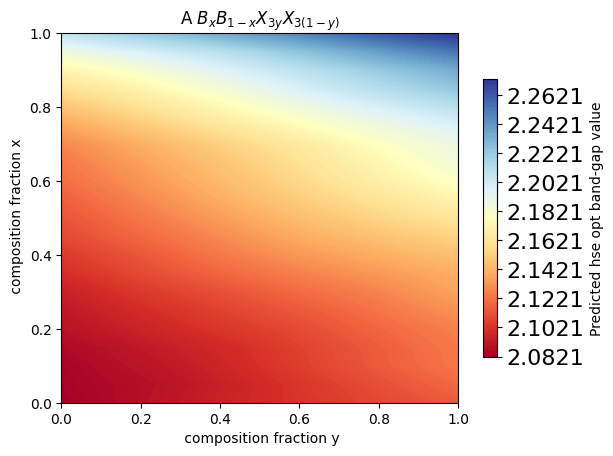

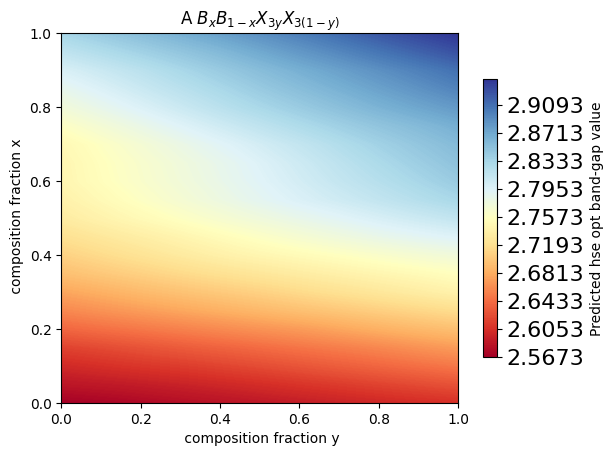

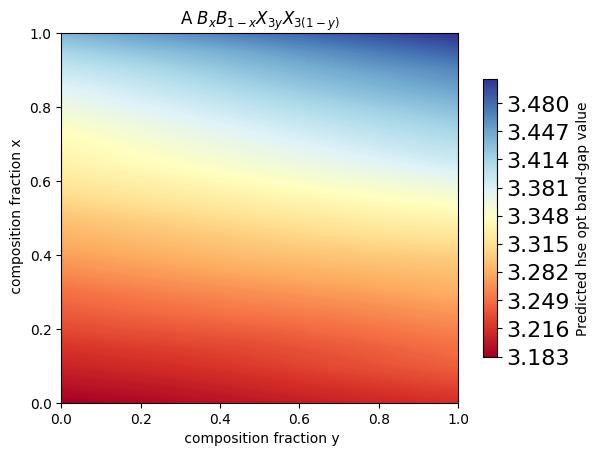

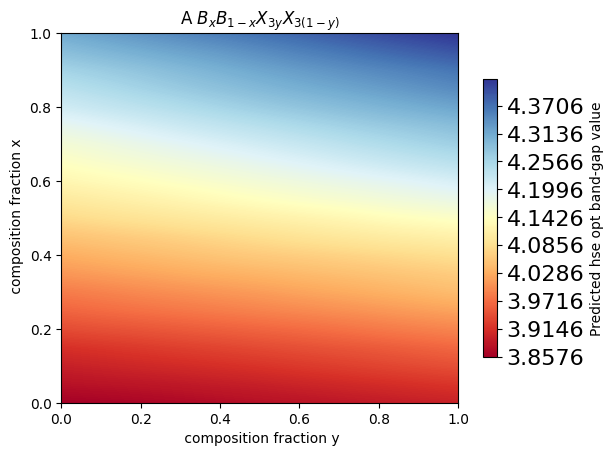

In [59]:
y,x = np.meshgrid(1-fracs, 1-fracs)
for idx in range(predarray.shape[-1]):
    fig, ax = plt.subplots()
    cont = ax.contourf(x,y, predarray[:,:,idx], levels = np.arange(predarray[:,:,idx].min(),predarray[:,:,idx].max(),0.001), cmap = 'RdYlBu')
    plt.title(r'A $B_{x} B_{1-x} X_{3y} X_{3(1-y)}$')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')
    ax.set_xlim(0.0,1.0)
    ax.set_xticks([i for i in np.arange(0,1.10,0.20)])

    ax.set_xlabel(' composition fraction y')
    ax.set_ylabel(' composition fraction x')

    cb = plt.colorbar(cont,  shrink=0.75, orientation = 'vertical')
    cb.ax.tick_params(labelsize = 16)      
    cb.set_label(f'Predicted {bg_labels[item]} band-gap value')

    plt.show()
